# Imports 

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import figure, show, setp
from mpl_toolkits.mplot3d import Axes3D
from statistics import mean
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.random.seed(7)

# Define Parameters

In [248]:
a = 0.5
b = 2.0
c = 4.0

# reservoir parameters 
N = 100
rho = 1.0                        # spectral radius 
D = 20                           # average degree 
sigma = 0.01                     # scale of input weights 
xi = 1.0                         # bias constant 
alpha = 1.0                      # leakage rate 
delta_t = 0.05                   # time interval 
T = 260                          # length of training phase 
K = int(T / delta_t)             # number of steps
t = np.linspace(0, T, K)         # time series ---> for 800 sample points
tau = 50                        # washout time

x = np.zeros(t.shape[0])
y = np.zeros(t.shape[0])
z = np.zeros(t.shape[0])

# Reservoir Network

In [249]:
def calculate_w_in(M):
    global N
    w_in = np.zeros([N, M])

    for m, n in enumerate(np.random.choice(M, N)):
            w_in[m, n] = np.random.uniform(-sigma, sigma)

    return w_in

def calculate_adjacancy_matrix():
    A = np.zeros([N, N])
    probability = D / N
    
    for di in range(D):
        for dj in range(di, D):
            if np.random.rand() < probability:
                A[di, dj] = np.random.uniform(-1, 1)
                A[dj, di] = A[di, dj]
    
    eigenvalues, _ = np.linalg.eig(A)
    A = (A / np.abs(np.max(eigenvalues))) * rho

    return A

def calculate_reservoir_states(M, u, A, W):
    global N, alpha, tau
    reservoir_state_list = []

    r = np.zeros([N, M])
    for m, n in enumerate(np.random.choice(M, N)):
            r[m, n] = np.random.uniform(-0.005, 0.005)

    reservoir_state_list.append(r)

    # implement washout time 
    u = np.pad(u, (tau, 0), 'constant', constant_values=(0, 0))

    for index, val in enumerate(u):
        if index % 500 == 0:
            print("Calculating: ", index)
            
        first = np.matmul(A, reservoir_state_list[index])
        second = np.matmul(W, np.array([[u[index]]]))
        third = xi * np.ones((N, 1))
        
        r_plus_t = reservoir_state_list[index] + np.tanh(first + second + third)
        reservoir_state_list.append(r_plus_t)

    return reservoir_state_list[tau+1:]

# Rossler System

### Generate Data 

In [250]:
def num_rossler(x_n, y_n, z_n):
    global a, b, c 
    
    x_n1 = x_n + delta_t * (- y_n - z_n)
    y_n1 = y_n + delta_t * (x_n + a * y_n)
    z_n1 = z_n + delta_t * (b + z_n * (x_n - c))   

    return x_n1, y_n1, z_n1

def get_rossler_data():
    for i in range(x.size-1):
        x[i+1], y[i+1], z[i+1] = num_rossler(x[i], y[i], z[i])
    
    x_mean = np.mean(x)
    x_variance = np.var(x)
    x_normed = (x - x_mean) / x_variance

    y_mean = np.mean(y)
    y_variance = np.var(y)
    y_normed = (y - y_mean) / y_variance

    z_mean = np.mean(z)
    z_variance = np.var(z)
    z_normed = (z - z_mean) / z_variance

    return x_normed, y_normed, z_normed

In [251]:
def train_test_split(x, y, z):
    train_x = x[ : int((len(x) + 1) * .60)] 
    test_x = x[int((len(x) + 1) * .60):]

    train_y = y[ : int((len(y) + 1) * .60)] 
    test_y = y[int((len(y) + 1) * .60):]

    train_z = z[ : int((len(z) + 1) * .60)] 
    test_z = z[int((len(z) + 1) * .60):]

    return train_x, test_x, train_y, test_y, train_z, test_z

In [252]:
x, y, z = get_rossler_data()
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z)
A = calculate_adjacancy_matrix()
W_in = calculate_w_in(1)
r = calculate_reservoir_states(1, x_train, A, W_in)

Calculating:  0
Calculating:  500
Calculating:  1000
Calculating:  1500
Calculating:  2000
Calculating:  2500
Calculating:  3000


In [253]:
assert len(r) == len(x_train)
assert len(r) == len(y_train)
assert len(r) == len(z_train)

### Visualize

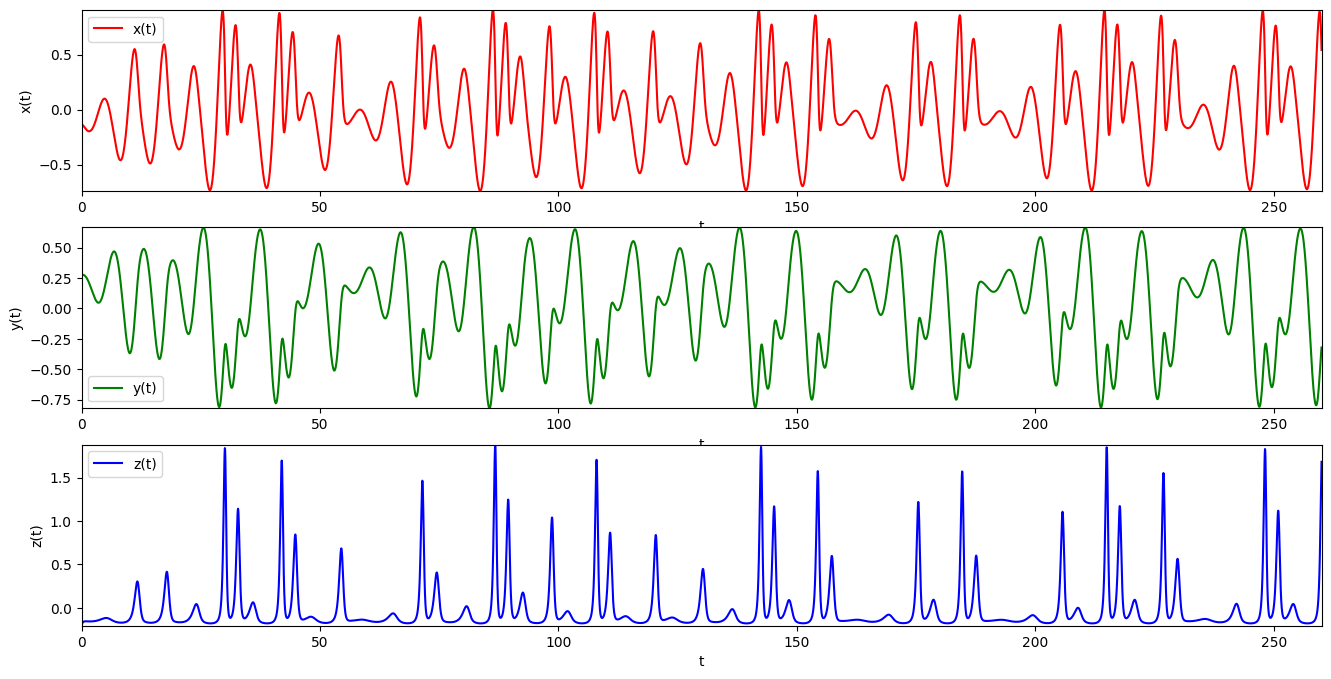

In [254]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(t, x, color='red', label='x(t)')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.legend()
ax1.axis((0, 260, min(x), max(x)))

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(t, y, color='green', label='y(t)')
ax2.set_xlabel('t')
ax2.set_ylabel('y(t)')
ax2.legend()
ax2.axis((0, 260, min(y), max(y)))

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(t, z, color='blue', label='z(t)')
ax3.set_xlabel('t')
ax3.set_ylabel('z(t)')
ax3.legend()
ax3.axis((0, 260, min(z), max(z)))

plt.savefig('Images/Problem_7/Rossler_x_y_z.pdf')
plt.show()

# Solve for W_out and Bias

In [255]:
r_bar = np.array(r).squeeze()
y_train = np.transpose(np.array(y_train))
z_train = np.transpose(np.array(z_train))
merged_output_train = np.concatenate((y_train[:, np.newaxis], z_train[:, np.newaxis]), axis=1)

model = LinearRegression()
model.fit(r_bar, merged_output_train)

w_out = np.array([model.coef_]).squeeze()
out_y = np.matmul(np.array([w_out[0]]), np.transpose(r_bar)) + model.intercept_[0]
out_y = out_y.squeeze().tolist()

out_z = np.matmul(np.array([w_out[1]]), np.transpose(r_bar)) + model.intercept_[1]
out_z = out_z.squeeze().tolist()

### Plotting for y(t)

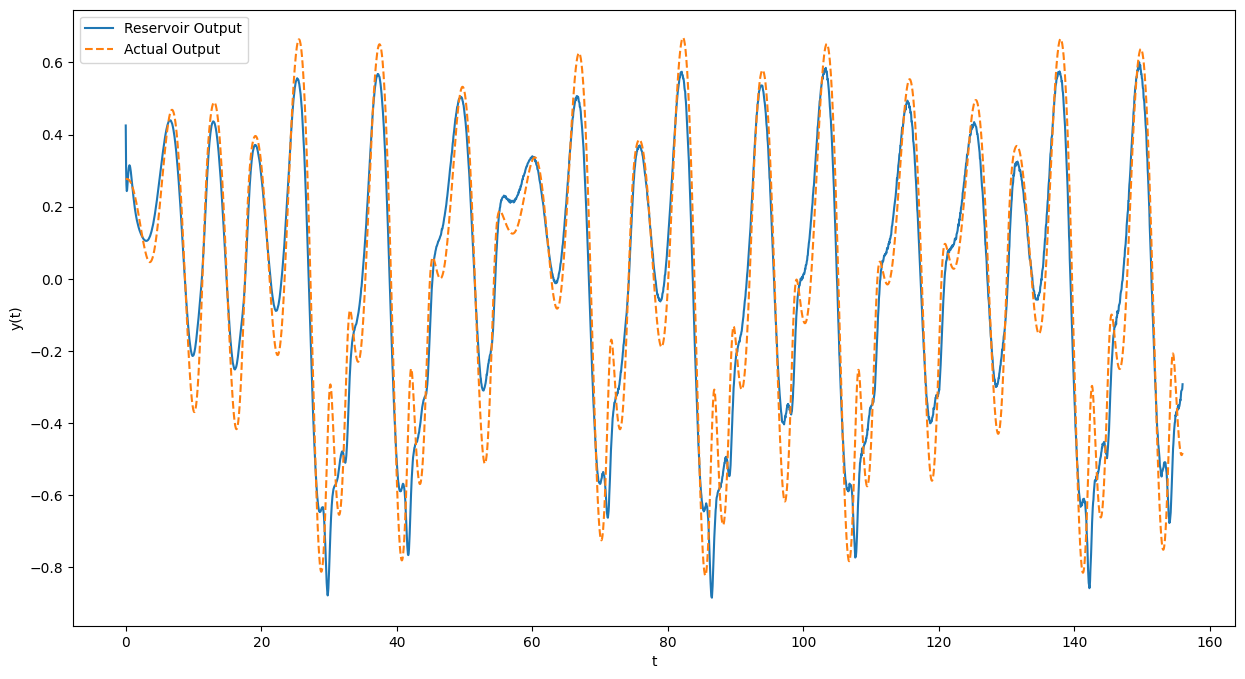

In [256]:
plt.figure(figsize=(15, 8))

plt.plot(t[:3120], out_y, label='Reservoir Output', linestyle='-', linewidth=1.5)
plt.plot(t[:3120], y_train, label='Actual Output', linestyle='--', linewidth=1.5)

plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()

plt.savefig('Images/Problem_7/Rossler_y(t).pdf')
plt.show()

In [257]:
mean_squared_error(out_y, y_train)

0.015249583134417731

### Plotting z(t)

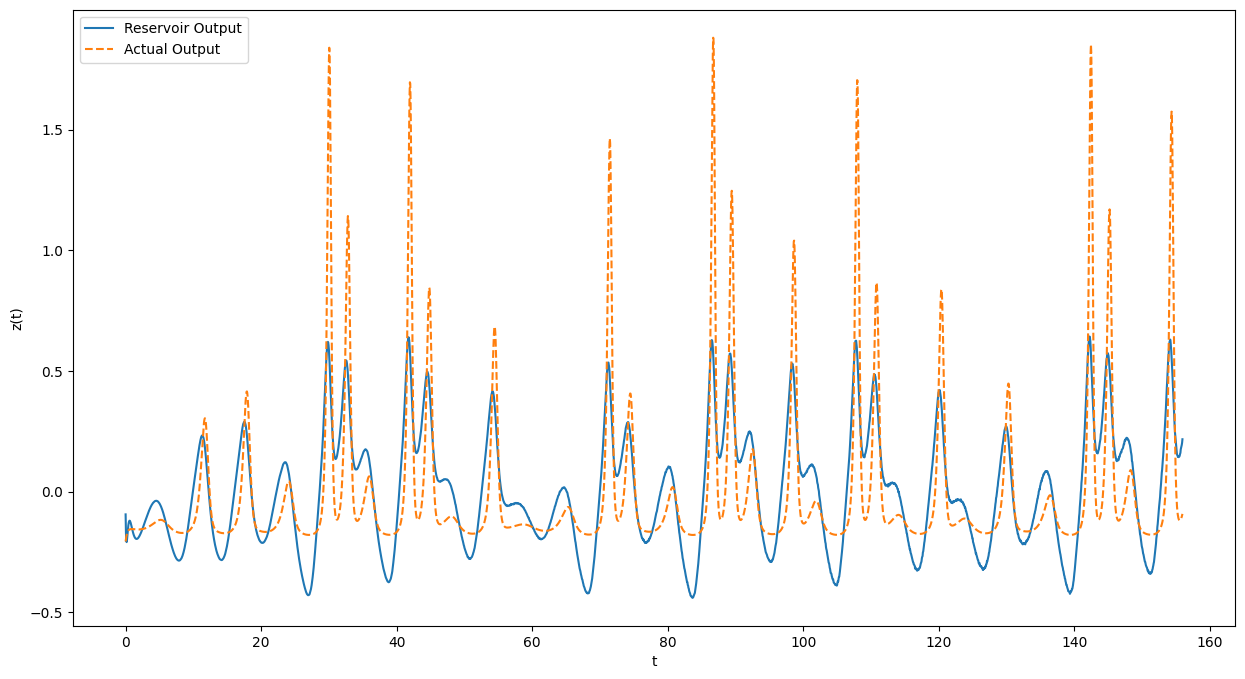

In [258]:
plt.figure(figsize=(15, 8))

plt.plot(t[:3120], out_z, label='Reservoir Output', linestyle='-', linewidth=1.5)
plt.plot(t[:3120], z_train, label='Actual Output', linestyle='--', linewidth=1.5)

plt.xlabel('t')
plt.ylabel('z(t)')
plt.legend()

plt.savefig("Images/Problem_7/Rossler_z(t).pdf")
plt.show()

In [259]:
mean_squared_error(out_z, z_train)

0.05011151465726305